In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')      
# !pip install transformers

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from datetime import datetime
import fnmatch
import itertools
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
import os
from pdb import set_trace
import pandas as pd
import pickle
import pprint
import random
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns
import warnings
import torch
import uuid
import time
import copy

import sys
sys.path.append("/content/drive/My Drive/collab/TADAT/") 
#local
from tadat.pipeline import plots
import tadat.core as core


warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

## Configs

In [3]:

# BASE_PATH = "/content/drive/My Drive/collab/MIMIC/"
BASE_PATH = "/Users/samir/Dev/projects/MIMIC/MIMIC/"
INPUT_PATH = BASE_PATH+"/DATA/input/"
FEATURES_PATH = BASE_PATH+"/DATA/features/"
OUTPUT_PATH = BASE_PATH+"/DATA/results/"
TMP_PATH = BASE_PATH+"/DATA/processed/"

TUNE_OUTPUT_PATH = BASE_PATH+"/DATA/results_fine/"
TUNE_TMP_PATH = BASE_PATH+"/DATA/processed_fine/"

GRID_OUTPUT_PATH = BASE_PATH+"/DATA/results_grid/"
GRID_TMP_PATH = BASE_PATH+"/DATA/processed_grid/"

#configs
N_SEEDS=8
N_VAL_SEEDS = 5
N_VAL_RUNS = 25
N_TASKS = 3
N_TASKS = 10
# PLOT_VARS=["auroc","auprc","sensitivity","specificity"]
PLOT_VARS=["auroc","sensitivity"]
MODEL="BERT-POOL"
PLOT_VAR = "auroc"

GROUPS = { "GENDER": ["M","F"],   
         "ETHNICITY": ["WHITE","BLACK","ASIAN","HISPANIC"]
}

CLASSIFIER = 'sklearn'
CLASSIFIER = 'torch'
# CLASSIFIER = 'mseq'
CLINICALBERT = "emilyalsentzer/Bio_ClinicalBERT"

In [4]:

SMALL_SIZE = 13
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Modeling 

In [5]:
def train_classifier(X_train, Y_train, X_val, Y_val, 
                     init_seed, shuffle_seed=None, input_dimension=None):    
    if CLASSIFIER == "torch":        
        x = core.models.MyLinearModel(in_dim=input_dimension, out_dim=1, 
                    loss_fn=torch.nn.BCEWithLogitsLoss(), 
                    init_seed=init_seed, n_epochs=500, 
                    default_lr=0.1, batch_size=None, 
                    shuffle_seed=shuffle_seed, silent=True,
                    shuffle=True) 
        x.fit(X_train, Y_train, X_val, Y_val)
    elif CLASSIFIER == "mseq":        
        x = core.models.MultiSeqLinearModel(in_dim=input_dimension, out_dim=1, 
                    loss_fn=torch.nn.BCELoss(), 
                    init_seed=init_seed, n_epochs=500, 
                    default_lr=0.1, batch_size=None, 
                    shuffle_seed=shuffle_seed, silent=True,
                    shuffle=True) 
        x.fit(X_train, Y_train, X_val, Y_val)
    elif CLASSIFIER == "sklearn":
        x = SGDClassifier(loss="log", random_state=shuffle_seed)
        x.fit(X_train, Y_train)
    else:
        raise NotImplementedError
    return x

def evaluate_classifier(model, X_test, Y_test,
                   labels, model_name, random_seed, subgroup, res_path=None):
    Y_hat = model.predict(X_test)
    Y_hat_prob = model.predict_proba(X_test)
    #get probabilities for the positive class
    if CLASSIFIER == 'sklearn':
        Y_hat_prob = Y_hat_prob[:,labels[1]]    
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    macroF1 = f1_score(Y_test, Y_hat, average="macro") 
    try:
        aurocc = roc_auc_score(Y_test, Y_hat_prob)
    except ValueError:
        aurocc = 0
    try:
        prec, rec, thresholds = precision_recall_curve(Y_test, Y_hat_prob)       
        auprc = auc(rec, prec)
    except ValueError:
        auprc = 0
    try:
        tn, fp, fn, tp = confusion_matrix(Y_test, Y_hat).ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp / (fn+tp)
    except ValueError:
        specificity, sensitivity = 0, 0
    
    res = {"model":model_name, 
            "seed":random_seed,  
            "group":subgroup,    
            "microF1":round(microF1,3),
            "macroF1":round(macroF1,3),
            "auroc":round(aurocc,3),
            "auprc":round(auprc,3),
            "specificity":round(specificity,3),
            "sensitivity":round(sensitivity,3)           
            }

    if res_path is not None:    
        core.helpers.save_results(res, res_path, sep="\t")
    return res

def tune_classifier(train_X, train_Y, val, feature_matrix, label_vocab, 
                    feature_type, seeds, metric):
    best_model = None
    best_perf = -1
    best_seed = None
    runs = {}    
    #all seed pairs
    val_idx, val_Y = val["all"]    
    val_X = feature_matrix[val_idx, :] 
    for init_seed, shuffle_seed in itertools.product(seeds,repeat=2):        
        seed = "{}x{}".format(init_seed, shuffle_seed)    
        model = train_classifier(train_X, train_Y,
                                     val_X, val_Y, init_seed=init_seed,
                                     shuffle_seed=shuffle_seed, 
                                     input_dimension=train_X.shape[1])
        
        res = evaluate_classifier(model, val_X, val_Y, 
                                  label_vocab, feature_type, seed, subgroup="val")
        try:
            perf = res[metric]
        except KeyError:
            raise KeyError("Metric {} Unknown".format(metric))        
        runs[seed] = perf
        if perf > best_perf:
            best_perf = perf
            best_model = model
            best_seed = seed
    return best_model, best_perf, best_seed, runs

def tune_fair_classifier(train_X, train_Y, val, feature_matrix,
                         label_vocab, feature_type, seeds, metric):
    best_model = None
    best_perf = -1
    best_seed = None
    runs = {}    
    val_idx, val_Y = val["all"]    
    val_X = feature_matrix[val_idx, :] 
    #all seed pairs
    for init_seed, shuffle_seed in itertools.product(seeds,repeat=2):                
        seed = "{}x{}".format(init_seed, shuffle_seed)
        model = train_classifier(train_X, train_Y,
                                     val_X, val_Y, init_seed=init_seed,
                                     shuffle_seed=shuffle_seed, 
                                     input_dimension=train_X.shape[1])
        
        perfs_sub = []
        for subgroup in val.keys():                                
            val_idx_sub, val_Y_sub = val[subgroup]                 
            val_X_sub = feature_matrix[val_idx_sub, :]                
            res_sub = evaluate_classifier(model, val_X_sub, val_Y_sub, 
                                          label_vocab, feature_type, seed, subgroup)                
        
            try:
                perfs_sub.append(res_sub[metric])
            except KeyError:
                raise KeyError("Metric {} Unknown".format(metric))
        #macro average subgroup performance
        perf = np.mean(perfs_sub) - np.std(perfs_sub)
        # std = np.std(perfs_sub)
        # print("fair tuning {} | perf:{}/std:{}".format(seed, round(perf,3), round(std,3)))
        runs[seed] = perf
        if perf > best_perf:
            best_perf = perf
            best_model = copy.deepcopy(model)
            best_seed = seed
    return best_model, best_perf, best_seed, runs



def vectorize(df_train, df_val, df_test, subject_ids):
    #vectorize labels
    train_Y = df_train["Y"]
    val_Y = df_val["Y"]           
    test_Y = df_test["Y"]           
    
    label_vocab = core.vectorizer.get_labels_vocab(train_Y+val_Y)
    train_Y,_ = core.vectorizer.label2idx(train_Y, label_vocab)
    val_Y,_ = core.vectorizer.label2idx(val_Y, label_vocab)
    test_Y,_ = core.vectorizer.label2idx(test_Y, label_vocab)
    
    
    #get the subject id indices
    train_idxs = [subject_ids.index(i) for i in list(df_train["SUBJECT_ID"])] 
    val_idxs = [subject_ids.index(i) for i in list(df_val["SUBJECT_ID"])] 
    test_idxs = [subject_ids.index(i) for i in list(df_test["SUBJECT_ID"])] 
    
    train = {}
    test = {}
    val = {}
    train["all"] = [train_idxs, train_Y]
    test["all"] = [test_idxs, test_Y]
    val["all"] = [val_idxs, val_Y]

    for group in list(GROUPS.keys()):
        #and subgroups
        for subgroup in GROUPS[group]:                
            df_train_sub = df_train[df_train[group] == subgroup]
            df_test_sub = df_test[df_test[group] == subgroup]
            df_val_sub = df_val[df_val[group] == subgroup]
            print("[subgroup: {} | tr: {} | ts: {} | val: {}]".format(subgroup, len(df_train_sub), len(df_test_sub), len(df_val_sub)))
            #vectorize labels               
            train_Y_sub,_ = core.vectorizer.label2idx(df_train_sub["Y"], label_vocab)            
            test_Y_sub,_ = core.vectorizer.label2idx(df_test_sub["Y"], label_vocab)            
            val_Y_sub,_ = core.vectorizer.label2idx(df_val_sub["Y"], label_vocab)            

            #get indices into the feature matrix
            train_idxs_sub = [subject_ids.index(i) for i in list(df_train_sub["SUBJECT_ID"])] 
            test_idxs_sub = [subject_ids.index(i) for i in list(df_test_sub["SUBJECT_ID"])] 
            val_idxs_sub = [subject_ids.index(i) for i in list(df_val_sub["SUBJECT_ID"])] 
            if subgroup == "M":
                subgroup = "men"
            elif subgroup == "F":
                subgroup = "women"
            train[subgroup.lower()] = [train_idxs_sub, train_Y_sub]
            test[subgroup.lower()] = [test_idxs_sub, test_Y_sub]
            val[subgroup.lower()] = [val_idxs_sub, val_Y_sub]

    return train, val, test, label_vocab


def get_features(data, vocab_size, feature_type, word_vectors=None):
    if feature_type == "BOW-BIN":
        X = core.features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-FREQ":
        X = core.features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-BIN":
        X = core.features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-SUM": 
        X = core.features.BOE(data, word_vectors,"sum")
    elif feature_type == "BERT-POOL":
        X =  core.transformer_encoders.encode_sequences(data, batchsize=64)        
    elif feature_type == "BERT-CLS":
        X =  core.transformer_encoders.encode_sequences(data, cls_features=True,
                                                        batchsize=64)            
    elif feature_type == "MULTI-BERT-POOL":
        X =  core.transformer_encoders.encode_multi_sequences(data, 10, batchsize=32,
                                                         tmp_path=TMP_PATH)
    elif feature_type == "MULTI-BERT-CLS":
        X =  core.transformer_encoders.encode_multi_sequences(data, 10, 
                                                         cls_features=True,
                                                         batchsize=32,
                                                         tmp_path=TMP_PATH)
    elif feature_type == "CLINICALBERT-POOL":
        tokenizer, encoder = core.transformer_encoders.get_encoder(CLINICALBERT)
        X =  core.transformer_encoders.encode_sequences(data, batchsize=64, tokenizer=tokenizer,
                                                                    encoder=encoder)        
    elif feature_type == "CLINICALBERT-CLS":
        tokenizer, encoder = core.transformer_encoders.get_encoder(CLINICALBERT)
        X =  core.transformer_encoders.encode_sequences(data, cls_features=True,batchsize=64,
                                                                    tokenizer=tokenizer, encoder=encoder)        
    elif feature_type == "CLINICALMULTI-BERT-POOL":
        tokenizer, encoder = core.transformer_encoders.get_encoder(CLINICALBERT)
        X =  core.transformer_encoders.encode_multi_sequences(data, 10, batchsize=32,tmp_path=TMP_PATH,
                                                              tokenizer=tokenizer, encoder=encoder)
    elif feature_type == "CLINICALMULTI-BERT-CLS":
        tokenizer, encoder = core.transformer_encoders.get_encoder(CLINICALBERT)
        X =  core.transformer_encoders.encode_multi_sequences(data, 10, cls_features=True, 
                                                                batchsize=32,tmp_path=TMP_PATH,
                                                                tokenizer=tokenizer, encoder=encoder)
    else:
        raise NotImplementedError
    return X

def extract_features(feature_type, path):
    X = read_cache(path+"feats_{}".format(feature_type))
    if X:
        print("[reading cached features]")
        subject_ids, X_feats = X
    else:
        print("[computing {} features]".format(feature_type))
        df = pd.read_csv(path+"patients.csv", sep="\t", header=0)
        subject_ids = list(df["SUBJECT_ID"])
        docs = list(df["TEXT"])
        if "BERT" in feature_type:
            X_feats = get_features(docs, None, feature_type)
        else:
            X, word_vocab = core.vectorizer.docs2idx(docs)
            X_feats = get_features(X,len(word_vocab),feature_type)
        #save features
        print("[saving features]")
        write_cache(path+"feats_{}".format(feature_type), 
                    [subject_ids, X_feats])
    return subject_ids, X_feats



# Run

In [6]:
def read_dataset(path, dataset_name, df_patients):    
    df_train = pd.read_csv("{}/{}_train.csv".format(path, dataset_name), 
                           sep="\t", header=0)
    df_test  = pd.read_csv("{}/{}_test.csv".format(path, dataset_name),
                           sep="\t", header=0)
    df_val   = pd.read_csv("{}/{}_val.csv".format(path, dataset_name),
                           sep="\t", header=0)
    #set indices
    df_patients.set_index("SUBJECT_ID", inplace=True)
    df_train.set_index("SUBJECT_ID", inplace=True)
    df_test.set_index("SUBJECT_ID", inplace=True)
    df_val.set_index("SUBJECT_ID", inplace=True)

    df_train = df_train.join(df_patients, on="SUBJECT_ID", 
                             how="inner", lsuffix="N_").reset_index()
    df_test = df_test.join(df_patients, on="SUBJECT_ID", 
                           how="inner", lsuffix="N_").reset_index()
    df_val = df_val.join(df_patients, on="SUBJECT_ID", 
                         how="inner", lsuffix="N_").reset_index()

    return df_train, df_test, df_val   


def read_cache(path):
    X = None
    try:
        with open(path, "rb") as fi:            
            X = pickle.load(fi)
    except FileNotFoundError:
        pass
    return X

def write_cache(path, o):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path, "wb") as fo:
        pickle.dump(o, fo)
        
def clear_cache(cache_path, model="*", dataset="*", group="*", ctype="*"):
    assert ctype in ["*","res*","feats"]
    file_paths = os.listdir(cache_path)
    pattern = "{}_{}_{}_*_{}.pkl".format(dataset, model, group, ctype).lower()
    for fname in file_paths:
        if fnmatch.fnmatch(fname, pattern):
            os.remove(cache_path+"/"+fname)
            print("cleared file: {}".format(fname))      

def run(data_path, dataset, features_path, feature_type, cache_path):
    #read patients data
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])

    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)
    
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[{} classifier]".format(CLASSIFIER))
    subject_ids, feature_matrix = extract_features(feature_type, features_path)      
    train, val, test, label_vocab = vectorize(df_train, df_val, df_test, subject_ids)
    train_idx, train_Y = train["all"]
    val_idx, val_Y = val["all"]
    #slice the feature matrix to get the corresponding instances
    train_X = feature_matrix[train_idx, :]    
    val_X = feature_matrix[val_idx, :]    
    random.seed(1) #ensure repeateable runs 
    random_seeds = random.sample(range(0, 10000), N_SEEDS)        
    incremental_results = {}     
    ##train/test classifier for each random seed pair
    for init_seed, shuffle_seed in itertools.product(random_seeds,repeat=2):        
        seed = "{}x{}".format(init_seed, shuffle_seed)
        res_fname = "{}_{}_res{}.pkl".format(dataset, feature_type, seed).lower()                
        #look for cached results
        curr_results = None
        if cache_path: curr_results = read_cache(cache_path+res_fname)              
        if not curr_results:
            curr_results = {}
            print(" > seed: {}".format(seed))                        
            model = train_classifier(train_X, train_Y,val_X, val_Y,  
                                     input_dimension=train_X.shape[-1],
                                     init_seed=init_seed, 
                                     shuffle_seed=shuffle_seed)                                                      
            #test each subgroup (note thtat *all* is also a subgroup)
            for subgroup in test.keys():                                
                test_idx_sub, test_Y_sub = test[subgroup]                 
                test_X_sub = feature_matrix[test_idx_sub, :]                
                res_sub = evaluate_classifier(model, test_X_sub, test_Y_sub, 
                                            label_vocab, feature_type, seed, subgroup)                
                curr_results[subgroup]= res_sub               
            #cache results
            if cache_path: write_cache(cache_path+res_fname, curr_results)                
        else:
            print("loaded cached results | seed: {}".format(seed))        
        
        incremental_results = merge_results(curr_results, incremental_results, 
                                            list(test.keys()))
    #build dataframes 
    df_results = results_to_df(incremental_results, test.keys())
    return df_results




def tune_run(data_path, dataset, features_path, feature_type, cache_path, tune_metric, fairness=False):
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])
    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[{} classifier]".format(CLASSIFIER))
    subject_ids, feature_matrix = extract_features(feature_type, features_path)
    train, val, test, label_vocab = vectorize(df_train, df_val, df_test, subject_ids)
    train_idx, train_Y = train["all"]
    #slice the feature matrix to get the corresponding instances
    train_X = feature_matrix[train_idx, :]    
    random.seed(1) #ensure repeateable runs 
    random_seeds = random.sample(range(0, 10000), N_VAL_RUNS*N_VAL_SEEDS)        
    incremental_results = {}     
    
    for i in range(N_VAL_RUNS):        
        res_fname = "{}_{}_tuned_res{}.pkl".format(dataset, feature_type, i).lower()
        #look for cached results
        curr_results = None
        if cache_path: curr_results = read_cache(cache_path+res_fname)              
        if not curr_results:
            curr_results = {}
            seeds = random_seeds[i*N_VAL_SEEDS:(i+1)*N_VAL_SEEDS]
            if fairness:
                model, perf, best_seed, val_run = tune_fair_classifier(train_X, train_Y, 
                                                              val, feature_matrix, label_vocab,
                                                              feature_type, seeds, tune_metric)               
            else:
                model, perf, best_seed, val_run = tune_classifier(train_X, train_Y, 
                                                              val, feature_matrix, label_vocab,
                                                              feature_type, seeds, tune_metric)               

            print("[seed: {}| {}: {}]".format(best_seed, tune_metric, round(perf,3)))    
                                                    
            #test each subgroup (note thtat *all* is also a subgroup)
            for subgroup in test.keys():                                
                test_idx_sub, test_Y_sub = test[subgroup]                 
                test_X_sub = feature_matrix[test_idx_sub, :]                
                res_sub = evaluate_classifier(model, test_X_sub, test_Y_sub, 
                                            label_vocab, feature_type, best_seed, subgroup)                
                curr_results[subgroup]= res_sub               
            #cache results
            if cache_path: write_cache(cache_path+res_fname, curr_results)                
        else:
            print("loaded cached results | run: {}".format(i))        
        
        incremental_results = merge_results(curr_results, incremental_results, 
                                            list(test.keys()))
    #build dataframes 
    df_results = results_to_df(incremental_results, test.keys())
    return df_results

def merge_results(curr_results, results, subgroups):
    #append results    
    for subgroup in subgroups:                
        res = curr_results[subgroup]
        try:
            results[subgroup].append(res)            
        except KeyError:
            results[subgroup] = []
            results[subgroup].append(res)            
    return results

def results_to_df(results, subgroups):
    df_results = {}
    df_res = pd.DataFrame(results["all"])            
    for subgroup in subgroups:        
        # if subgroup == "all": continue
        df_res_g = pd.DataFrame(results[subgroup])        
        df_res_delta = df_res_g.sub(df_res.iloc[:,3:])
        # from pdb import set_trace; set_trace()
        df_res_delta["model"] = df_res_g["model"]
        df_res_delta["seed"] = df_res_g["seed"]
        df_res_delta["group"] = df_res_g["group"] 
        df_results[subgroup] = {}
        df_results[subgroup]["results"] = df_res_g
        df_results[subgroup]["delta"] = df_res_delta
        
    return dict(df_results)



# Analyses

In [7]:
def run_analyses(data_path, dataset, features_path, feature_type, results_path, 
                 cache_path, clear_results=False, tune_metric=None, plot_metric="auroc", fairness=False):    

    if clear_results:
        clear_cache(cache_path, model=feature_type, dataset=dataset, ctype="res*")
    if tune_metric: 
        best_seeds = grid_search(data_path, dataset, features_path, feature_type, cache_path, tune_metric)  
        df_results = test_seeds(data_path, dataset, features_path, feature_type, results_path, tune_metric, best_seeds)  
        
        fname = "{}_{}_{}_all_tuned.pkl".format(dataset, feature_type, tune_metric).lower()
    else:
        df_results = run(data_path, dataset, features_path, feature_type, cache_path)         
        fname = "{}_{}_all_res.pkl".format(dataset, feature_type).lower()
        
    #save results
    if not os.path.exists(results_path): os.makedirs(results_path)  
    write_cache(results_path+fname, df_results)
    if plot_metric:           
        plot_scatters(df_results, plot_metric, dataset)
        plot_deltas(df_results, plot_metric, dataset)
    return df_results               

#Run All the tasks
def run_tasks(data_path, tasks_fname, features_path, feature_type, results_path, cache_path,  
             reset=False, tune_metric=None, plot_metric=None, mini_tasks=True):
    #if reset delete the completed tasks file
    if reset: reset_tasks(cache_path)    
    with open(data_path+tasks_fname,"r") as fid:
        for i,l in enumerate(fid):
            if i > N_TASKS: break
            fname, task_name = l.strip("\n").split(",")            
            dataset = "mini-"+fname if mini_tasks else fname
            # dataset = fname
            if is_task_done(cache_path, dataset): 
                print("[dataset: {} already processed]".format(dataset))
                continue                        
            print("******** {} {} ********".format(task_name, dataset))      
            run_analyses(data_path, dataset, features_path, feature_type, results_path, 
                         cache_path, clear_results=False, tune_metric=tune_metric, 
                         plot_metric=plot_metric)
            task_done(cache_path, dataset)

def task_done(path,  task):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path+"completed_tasks.txt", "a") as fod:
        fod.write(task+"\n")

def reset_tasks(path):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path+"completed_tasks.txt", "w") as fod:
        fod.write("")

def is_task_done(path,  task):
    try:
        with open(path+"completed_tasks.txt", "r") as fid:
            tasks = fid.read().split("\n")            
        return task in set(tasks)
    except FileNotFoundError:
        #create file if not found
        dirname = os.path.dirname(path)
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        with open(path+"completed_tasks.txt", "w") as fid:
            fid.write("")
        return False

def plot_densities(df, ax, title):
    ax.set_title(title)
    for y in PLOT_VARS:        
        try:
            df.plot.kde(ax=ax, x="seed", y=y)
        except:
            pass

def plot_scatters(results, metric, title):
    n_rows=2
    n_cols = 3    
    fig, ax = plt.subplots(n_rows, n_cols,  figsize=(12,5), sharex=True, sharey=True)
    #current coloramap
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    coords = list(itertools.product(range(n_rows),range(n_cols)))   
    subgroups = list(results.keys())
    subgroups.remove('all')
    df = results['all']["results"]
    for subgroup, col, coord in zip(subgroups, cmap, coords ):
        df_delta = results[subgroup]["delta"]        
        df_all = df.merge(df_delta, on=["model","seed"],
                                      suffixes=[None, "_delta"])
        #get absolute values for the deltas    
        df_all[metric+"_delta"] = df_all[metric+"_delta"].abs() 
        df_all.plot.scatter(x=metric,y=metric+"_delta",
                            c=col, ax=ax[coord[0]][coord[1]])
        ax[coord[0]][coord[1]].set_title(subgroup)
        ax[coord[0]][coord[1]].set_ylabel("delta")
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    
def plot_deltas(results, metric, title):
    df_delta = pd.concat([results[g]["delta"] for g in list(results.keys()) if g != "all"])    
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model","group"], 
                                  value_vars=[metric], 
                                  var_name="metric", value_name="delta")
    g = sns.catplot(x="group", y="delta", data=df_delta_long, 
                    sharey=True,legend=False)    
    lim = max(df_delta_long["delta"].abs()) + 0.05
    
    for ax in g.axes[0]:
        ax.axhline(0, ls='--',c="r")
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()  

def plot_analyses(results_path, dataset, task_name, feature_type, plot_metric, tune_metric=None):
    if tune_metric:
        fname = "{}_{}_all_tuned_res.pkl".format(dataset, feature_type).lower()
    else:        
        fname = "{}_{}_all_res.pkl".format(dataset, feature_type).lower()

    df_results = read_cache(results_path+fname)
    if df_results:
        plot_scatters(df_results, plot_metric, task_name)
        plot_deltas(df_results, plot_metric, task_name)


def plot_tasks(tasks_fname, feature_type, results_path, 
               mini_tasks=True, plot_metric=None, tune_metric=None):
    with open(tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):            
            fname, task_name = l.strip("\n").split(",")
            dataset = "mini-"+fname if mini_tasks else fname
            plot_analyses(results_path, dataset, task_name, feature_type, plot_metric, tune_metric)

    plot_gaps(tasks_fname, feature_type, results_path, mini_tasks=mini_tasks, 
              plot_metric=plot_metric, tune_metric=tune_metric)
    plot_performances(tasks_fname, feature_type, results_path, mini_tasks=mini_tasks, 
              plot_metric=plot_metric, tune_metric=tune_metric)

def get_gaps(results, dataset_name, metric):    
    all_dfs = [results[g]["results"][["seed", metric]] for g in results.keys()]
    all_dfs = pd.concat(all_dfs)
    diff_df = (all_dfs.groupby("seed").max() - all_dfs.groupby("seed").min()).reset_index()
    diff_df["dataset"] = [dataset_name]*len(diff_df)
    return diff_df

def plot_gaps(tasks_fname, feature_type, results_path, 
               mini_tasks=True, plot_metric=None, tune_metric=None):
    dfs = []                                                                    
    with open(tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):            
            task_abv, task_name = l.strip("\n").split(",")
            dataset = "mini-"+task_abv if mini_tasks else task_abv
            if tune_metric:
                fname = "{}_{}_all_tuned_res.pkl".format(dataset, feature_type).lower()
            else:        
                fname = "{}_{}_all_res.pkl".format(dataset, feature_type).lower()

            df_results = read_cache(results_path+fname)    
            if df_results:
                df_gaps = get_gaps(df_results, task_abv, plot_metric)
                dfs.append(df_gaps)
    dfs = pd.concat(dfs)
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    g = sns.catplot(x=plot_metric,y="dataset", data=dfs, sharey=True,legend=True, 
                    legend_out=True, height=6, aspect=0.85,palette=cmap)        
    g.set_xlabels(plot_metric + " gap")
    plt.tight_layout()
    plt.show()  
    
def plot_performances(tasks_fname, feature_type, results_path, 
               mini_tasks=True, plot_metric=None, tune_metric=None):
    dfs = []
    with open(tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):            
            task_abv, task_name = l.strip("\n").split(",")
            dataset = "mini-"+task_abv if mini_tasks else task_abv
            if tune_metric:
                fname = "{}_{}_all_tuned_res.pkl".format(dataset, feature_type).lower()
            else:        
                fname = "{}_{}_all_res.pkl".format(dataset, feature_type).lower()

            df_results = read_cache(results_path+fname)    
            if df_results:
                df = df_results["all"]["results"]
                df["dataset"] = [task_abv]*len(df)
                dfs.append(df)
    dfs = pd.concat(dfs)
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    g = sns.catplot(x=plot_metric,y="dataset", data=dfs, sharey=True,legend=True, 
                    legend_out=True, height=6, aspect=0.85,palette=cmap)        
#     g.set_xlabels(plot_metric + " gap")
    plt.tight_layout()
    plt.show()  



In [54]:
def grid_search(data_path, dataset, features_path, feature_type, cache_path, tune_metric, n_runs=100):
    #read patients data
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])

    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)    
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[grid searching with {} classifier]".format(CLASSIFIER))
    subject_ids, feature_matrix = extract_features(feature_type, features_path)      
    train, val, test, label_vocab = vectorize(df_train, df_val, df_test, subject_ids)
    train_idx, train_Y = train["all"]
    val_idx, val_Y = val["all"]
    #slice the feature matrix to get the corresponding instances
    train_X = feature_matrix[train_idx, :]    
    val_X = feature_matrix[val_idx, :]    

    init_randomizer = RandomState(1)
    shuffle_randomizer = RandomState(2)    
    results = []
    dirname = os.path.dirname(cache_path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    res_fname = cache_path+"/grid_{}_{}_{}.pkl".format(dataset, feature_type, tune_metric).lower()    
    try:
        df_results = pd.read_csv(res_fname)
    except FileNotFoundError:
        df_results = pd.DataFrame(columns = ["seed"] +  list(val.keys()))
        df_results.to_csv(res_fname, index=False, header=True)        
    
    skip_seeds = set(df_results["seed"])
    ##train/test classifier for each random seed pair
    for j in range(n_runs):         
        init_seed = init_randomizer.randint(10000)
        shuffle_seed = shuffle_randomizer.randint(10000)
        seed = "{}x{}".format(init_seed, shuffle_seed)        
        if seed in skip_seeds:
            print("skipped seed: {}".format(seed))
            continue
        curr_results = {"seed":seed}
        print(" > seed: {}".format(seed))                        
        model = train_classifier(train_X, train_Y,val_X, val_Y,  
                                    input_dimension=train_X.shape[-1],
                                    init_seed=init_seed, 
                                    shuffle_seed=shuffle_seed)                                                                
        ####### VALIDATION ########
        
        #test each subgroup (note thtat *all* is also a subgroup)
        for subgroup in val.keys():                                
            val_idx_sub, val_Y_sub = val[subgroup]                 
            val_X_sub = feature_matrix[val_idx_sub, :]                
            res_sub = evaluate_classifier(model, val_X_sub, val_Y_sub, 
                                        label_vocab, feature_type, seed, subgroup)                
            curr_results[subgroup]= res_sub[tune_metric]          

        df_results = df_results.append(curr_results, ignore_index=True)
        df_results.to_csv(res_fname, index=False, header=True)    
        
    #return the best seeds    
    return get_best_seeds(df_results, val.keys())

def get_best_seeds(df_grid, groups, k=20):    
        
    for g in groups:
        df_grid["delta_"+g] = (df_grid["all"] - df_grid[g]).abs()    
    
    df_grid["perf_avg"] = df_grid[[g for g in groups]].mean(axis=1)
    df_grid["perf_std"] = df_grid[[g for g in groups]].std(axis=1)
    df_grid["perf_avg_std"] = df_grid["perf_avg"] - df_grid["perf_std"]
    df_grid["delta_avg"] = df_grid[["delta_"+g for g in groups]].mean(axis=1)
    df_grid["perf_avg_delta"] = df_grid["perf_avg"] - df_grid["delta_avg"]
    df_grid["all_avg_delta"] = df_grid["all"] - df_grid["delta_avg"]

    z = int(len(df_grid)/k)+1
    res = []
    for i in range(z):
        step = (i+1)*k
        df = df_grid.iloc[:step,:]      
        #get the seed with the minimum delta
        best_df = df.iloc[df["delta_avg"].idxmin()]
        seed = best_df["seed"]
        perf = best_df["delta_avg"]
        res.append({"seed":seed, "criterion":"delta_avg", "k":step, "val":perf })        
        #get seeds with max criteria
        for crit in ["all", "perf_avg", "perf_avg_std", "perf_avg_delta"]:        
            best_df = df.iloc[df[crit].idxmax()]
            seed = best_df["seed"]
            perf = best_df[crit]
            res.append({"seed":seed, "criterion":crit, "k":step, "val":perf })
        
        df_best_seeds = pd.DataFrame(res)       
        
    return df_best_seeds

def test_seeds(data_path, dataset, features_path, feature_type, cache_path, tune_metric, best_seeds):
    #read patients data
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])

    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)    
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[testing seeds with {} classifier]".format(CLASSIFIER))
    subject_ids, feature_matrix = extract_features(feature_type, features_path)      
    train, val, test, label_vocab = vectorize(df_train, df_val, df_test, subject_ids)
    train_idx, train_Y = train["all"]
    val_idx, val_Y = val["all"]
    #slice the feature matrix to get the corresponding instances
    train_X = feature_matrix[train_idx, :]    
    val_X = feature_matrix[val_idx, :]    
    groups = list(val.keys())
    dirname = os.path.dirname(cache_path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    res_fname = cache_path+"/test_seeds_{}_{}_{}.pkl".format(dataset, feature_type, tune_metric).lower()                    
    try:
        df_results = pd.read_csv(res_fname)
    except FileNotFoundError:
        cols = ["seed"] +  groups + ["delta_"+g for g in groups]
        df_results = pd.DataFrame(columns = cols)    
    skip_seeds = set(df_results["seed"])    
    for seed in set(best_seeds["seed"]):
        if seed in skip_seeds:
            print("skipped seed: {}".format(seed))
            continue 
        curr_results = {"seed":seed}
        print(" > seed: {}".format(seed))                        
        init_seed, shuffle_seed = seed.split("x") 
        model = train_classifier(train_X, train_Y,val_X, val_Y,  
                                    input_dimension=train_X.shape[-1],
                                    init_seed=int(init_seed), 
                                    shuffle_seed=int(shuffle_seed))
        ####### TEST ########
        
        #test each subgroup (note thtat *all* is also a subgroup)
        for subgroup in test.keys():                                
            test_idx_sub, test_Y_sub = test[subgroup]                 
            test_X_sub = feature_matrix[test_idx_sub, :]                
            res_sub = evaluate_classifier(model, test_X_sub, test_Y_sub, 
                                        label_vocab, feature_type, seed, subgroup)                
            curr_results[subgroup]= res_sub[tune_metric]          

        df_results = df_results.append(curr_results, ignore_index=True)
    
    for g in groups:
        df_results["delta_"+g] = (df_results["all"] - df_results[g]).abs()    
    
    df_results.to_csv(res_fname,index=False, header=True)
    best_seeds = best_seeds.set_index("seed")
    df_results = df_results.set_index("seed")
    df_final = best_seeds.join(df_results, how="inner", on=["seed"])
    df_final = df_final.sort_values(by=["criterion","k"])
    return df_final



def plot_gridsearch(cache_path, dataset, feature_type, tune_metric, title, delta=False):    
    res_fname = cache_path+"{}_{}_{}_all_tuned.csv".format(dataset, feature_type, tune_metric).lower()              
    df_results = pd.read_csv(res_fname)  
    fig, ax = plt.subplots(1, 5,  figsize=(25,8), sharex=True, sharey=True)    
    df_all = df_results[df_results["criterion"] == "all"]    
    best_all = df_all.iloc[df_all["k"].idxmax()]["all"]    
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    criteria = ["all", "perf_avg", "perf_avg_std", "delta_avg", "perf_avg_delta"]
    groups = ["all", "men", "women", "white", "black","asian", "hispanic"]
    df_results["delta_avg"] = df_results[["delta_"+g for g in groups]].mean(axis=1)
    if delta:
        groups = ["delta_" + l for l in groups]
    for i, criterion in enumerate(criteria):
        df = df_results[df_results["criterion"] == criterion]    
        ax[i].set_title(criterion)
        if delta:
            df.plot(x="k", y="delta_avg",   linewidth=4, ax=ax[i], c="gray")    
        else:
            ax[i].axhline(best_all, linewidth=2, c=cmap[0], linestyle="--")
            df.plot(x="k", y="all",   linewidth=4, ax=ax[i])    
        
        for g in groups[1:]:
            df.plot(x="k", y=g, style="o--", ax=ax[i])
            
        #place legend on the last subplot
        if i == len(criteria)-1: 
            ax[i].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
        else:
            ax[i].get_legend().remove()

    
#     lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
#     lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    
#     # Create the legend
#     fig.legend(lines,     # The line objects
#            labels,   # The labels for each line
#            loc="center right",   # Position of legend
#            borderaxespad=0.1,    # Small spacing around legend box
#            title="Legend Title"  # Title for the legend
#            )
#     fig.suptitle(title)

        
def plot_gridsearches(tasks_fname, feature_type, results_path, 
               mini_tasks=True, plot_metric=None, tune_metric=None):
    with open(tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):            
            fname, task_name = l.strip("\n").split(",")
            dataset = "mini-"+fname if mini_tasks else fname
        plot_gridsearch(cache_path, dataset, feature_type, tune_metric, task_name)

# Main

In [ ]:
dataset="IHM"
dataset="mini-"+dataset
CLASSIFIER="sklearn"
PLOT_METRIC="auroc"
TUNE_METRIC="auroc"
# Z = run_analyses(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, None, 
#              clear_results=False, tune_metric=TUNE_METRIC, plot_metric=None)
best_seeds = grid_search(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, TUNE_METRIC, n_runs=100)
test_seeds(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, TUNE_METRIC, best_seeds)

# plot_analyses(OUTPUT_PATH, dataset, MODEL, dataset, plot_metric=PLOT_METRIC, tune_metric=TUNE_METRIC)


In [29]:
dataset="IHM"
dataset="mini-"+dataset
CLASSIFIER="torch"
PLOT_METRIC="auroc"
TUNE_METRIC="auroc"
Z = run_analyses(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, TMP_PATH, 
             clear_results=False, tune_metric=TUNE_METRIC, plot_metric=None)
# plot_analyses(OUTPUT_PATH, dataset, MODEL, dataset, plot_metric=PLOT_METRIC, tune_metric=TUNE_METRIC)
Z

[train/test set size: 1000/1000]
[grid searching with torch classifier]
[reading cached features]
[subgroup: M | tr: 561 | ts: 545 | val: 556]
[subgroup: F | tr: 439 | ts: 455 | val: 444]
[subgroup: WHITE | tr: 711 | ts: 686 | val: 700]
[subgroup: BLACK | tr: 94 | ts: 104 | val: 103]
[subgroup: ASIAN | tr: 23 | ts: 11 | val: 23]
[subgroup: HISPANIC | tr: 25 | ts: 29 | val: 37]
 > seed: 235x7336
[early stopping: 176 epochs]
 > seed: 5192x2575
[early stopping: 174 epochs]
 > seed: 905x6637
[early stopping: 176 epochs]
 > seed: 7813x2514
[early stopping: 245 epochs]
 > seed: 2895x1099
[early stopping: 201 epochs]
 > seed: 5056x4770
[early stopping: 241 epochs]
 > seed: 144x433
[early stopping: 250 epochs]
 > seed: 4225x6751
[early stopping: 142 epochs]
 > seed: 7751x2773
[early stopping: 130 epochs]
 > seed: 3462x5167
[early stopping: 171 epochs]
 > seed: 9394x2778
[early stopping: 143 epochs]
 > seed: 5396x6548
[early stopping: 21 epochs]
 > seed: 5374x8316
[early stopping: 163 epochs]
 

,criterion,k,val,all,men,women,white,black,asian,hispanic,delta_all,delta_men,delta_women,delta_white,delta_black,delta_asian,delta_hispanic
seed,,,,,,,,,,,,,,,,,
7751x2773,all,20,0.757000,0.806,0.828,0.778,0.793,0.912,1.000,0.429,0.0,0.022,0.028,0.013,0.106,0.194,0.377
3606x31,all,40,0.779000,0.817,0.818,0.815,0.824,0.867,0.889,0.464,0.0,0.001,0.002,0.007,0.050,0.072,0.353
3606x31,all,60,0.779000,0.817,0.818,0.815,0.824,0.867,0.889,0.464,0.0,0.001,0.002,0.007,0.050,0.072,0.353
3606x31,all,80,0.779000,0.817,0.818,0.815,0.824,0.867,0.889,0.464,0.0,0.001,0.002,0.007,0.050,0.072,0.353
3606x31,all,100,0.779000,0.817,0.818,0.815,0.824,0.867,0.889,0.464,0.0,0.001,0.002,0.007,0.050,0.072,0.353
3606x31,all,120,0.779000,0.817,0.818,0.815,0.824,0.867,0.889,0.464,0.0,0.001,0.002,0.007,0.050,0.072,0.353
4225x6751,delta_avg,20,0.073857,0.792,0.826,0.753,0.801,0.799,0.639,0.982,0.0,0.034,0.039,0.009,0.007,0.153,0.190
1888x9541,delta_avg,40,0.075286,0.788,0.799,0.775,0.789,0.747,0.944,0.946,0.0,0.011,0.013,0.001,0.041,0.156,0.158
3098x5884,delta_avg,60,0.076714,0.774,0.779,0.767,0.783,0.736,0.944,0.857,0.0,0.005,0.007,0.009,0.038,0.170,0.083


In [ ]:
dataset="IHM"
# dataset="mini-"+dataset
CLASSIFIER="torch"
PLOT_METRIC="auroc"
TUNE_METRIC="auroc"
Z = run_analyses(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, None, 
             clear_results=False, tune_metric=TUNE_METRIC, plot_metric=PLOT_VAR, fairness=True)
plot_analyses(OUTPUT_PATH, dataset, MODEL, dataset, plot_metric=PLOT_METRIC, tune_metric=TUNE_METRIC)


In [ ]:
CLASSIFIER="torch"
# run_analyses(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, None, clear_results=False, tune_metric=None, subsample=False, plots=True)
plot_analyses(OUTPUT_PATH, dataset, MODEL, dataset, tune_metric=None)

In [ ]:
plot_performances(INPUT_PATH+"tasks.txt", MODEL, OUTPUT_PATH, mini_tasks=False, plot_metric=PLOT_VAR, tune_metric=None)

In [ ]:
#Run tasks
run_tasks(INPUT_PATH, "tasks.txt", FEATURES_PATH, MODEL, OUTPUT_PATH, TMP_PATH, reset=True, 
           tune_metric=TUNE_METRIC, plot_metric=None, mini_tasks=True)
# plot_tasks(INPUT_PATH+"tasks.txt", MODEL, OUTPUT_PATH, mini_tasks=False, plot_metric=PLOT_VAR, tune_metric=None)

  criterion    k    val    all    men  women  white  black  asian  hispanic  \
0       all   20  0.585  0.596  0.596  0.593  0.595  0.578  0.523      0.50   
1       all   40  0.596  0.571  0.589  0.546  0.567  0.552  0.606      0.47   
2       all   60  0.596  0.571  0.589  0.546  0.567  0.552  0.606      0.47   
3       all   80  0.596  0.571  0.589  0.546  0.567  0.552  0.606      0.47   
4       all  100  0.596  0.571  0.589  0.546  0.567  0.552  0.606      0.47   
5       all  120  0.596  0.571  0.589  0.546  0.567  0.552  0.606      0.47   

   delta_all  delta_men  delta_women  delta_white  delta_black  delta_asian  \
0        0.0      0.000        0.003        0.001        0.018        0.073   
1        0.0      0.018        0.025        0.004        0.019        0.035   
2        0.0      0.018        0.025        0.004        0.019        0.035   
3        0.0      0.018        0.025        0.004        0.019        0.035   
4        0.0      0.018        0.025        0.004  

   criterion    k       val    all    men  women  white  black  asian  \
12  perf_avg   20  0.579429  0.568  0.573  0.559  0.571  0.542  0.582   
13  perf_avg   40  0.591857  0.571  0.589  0.546  0.567  0.552  0.606   
14  perf_avg   60  0.591857  0.571  0.589  0.546  0.567  0.552  0.606   
15  perf_avg   80  0.592857  0.556  0.557  0.552  0.552  0.526  0.634   
16  perf_avg  100  0.603857  0.557  0.555  0.559  0.562  0.540  0.520   
17  perf_avg  120  0.603857  0.557  0.555  0.559  0.562  0.540  0.520   

    hispanic  delta_all  delta_men  delta_women  delta_white  delta_black  \
12     0.510        0.0      0.005        0.009        0.003        0.026   
13     0.470        0.0      0.018        0.025        0.004        0.019   
14     0.470        0.0      0.018        0.025        0.004        0.019   
15     0.488        0.0      0.001        0.004        0.004        0.030   
16     0.490        0.0      0.002        0.002        0.005        0.017   
17     0.490        0.0   

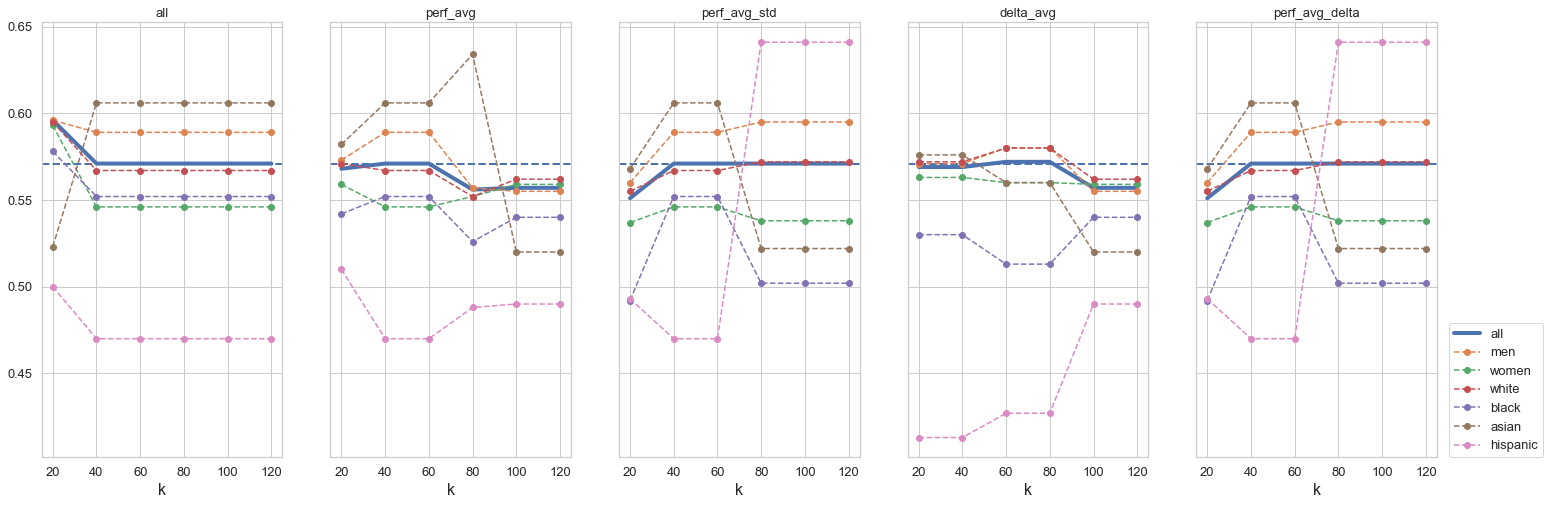

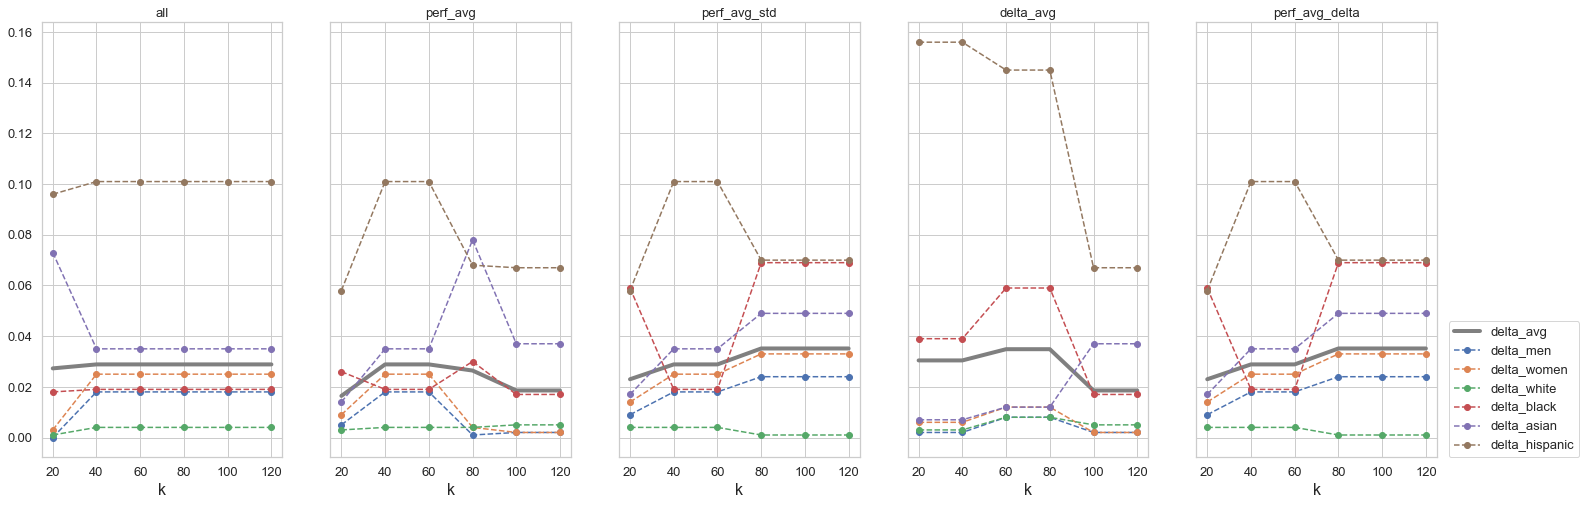

In [55]:
# results_path, dataset, feature_type, tune_metric
TUNE_METRIC="auroc"
plot_gridsearch(GRID_OUTPUT_PATH, "DOLM", MODEL, TUNE_METRIC, "DOLM")
plot_gridsearch(GRID_OUTPUT_PATH, "DOLM", MODEL, TUNE_METRIC, "DOLM", delta=True)

In [97]:
a = ["all","none"]
a

['all', 'none']

In [98]:
a.remove("all")
a

['none']